# Baseline model

TL;DR:

1. Rescale ranks of participants in each year according to the formula $r_{\text{rescaled}} = (n - r)/(n - 1)$, where $r$ is the rank and $n$ the number of participants in a year.
   This means that first place gets a rescaled rank of 1 ($r = 1$), and last place a rescaled rank of 0 ($r = n$).
   
2. Rescaled ranks for each country are averaged over the years 1998–2021.

3. To test the model, the Spearman correlation is calculated for the 2022 results.

4. Predictions made for 2023.

In [1]:
# Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../../data/df_main.csv')
df_2023 = pd.read_csv('../../data/df_2023.csv')

# 'Training'

In [2]:
def train(excluded_years=None):
    if excluded_years is None:
        excluded_years = []
        
    # Get maximum rank in each year
    df_rank_max = (df[['year', 'rank']]
                .query('year not in @excluded_years')
                .groupby('year')
                .agg('max')
                .rename({'rank': 'rank_max'}, axis=1)
                )
    
    # Rescale rank to go from 0 = last place (rank = rank_max) to 1 = first place (rank = 1).
    df_rank = (df[['to_code2', 'year', 'rank']]
                .query('year <= 2021')
                .drop_duplicates()
                .join(df_rank_max, how='left', on='year')
                .assign(rescaled_rank=lambda x: (x['rank_max'] - x['rank'])/(x['rank_max'] - 1))
                .groupby('to_code2')
                .agg({'rescaled_rank': 'mean'})
                .sort_values('rescaled_rank', ascending=False)
    )
    
    return df_rank

In [3]:
ranks_without_2022 = train(excluded_years=[2022])
ranks_without_2022.head()

,rescaled_rank
to_code2,
YU,0.847826
BG,0.757217
RU,0.751027
IT,0.744141
SE,0.693254


# 'Test'

In [4]:
def predict(rescaled_ranks, year):
    if year <= 2022:
        countries = df.query('year == @year')['to_code2'].unique()
    elif year == 2023:
        countries = df_2023['to_code2'].unique()
    predictions = (rescaled_ranks
                   .query('to_code2 in @countries')
                   .sort_values('rescaled_rank', ascending=False)
                   .reset_index())
    predictions['predicted_rank'] = predictions.index + 1
    predictions = predictions.set_index('to_code2')
    return predictions
    
def get_actual_ranks(year):
    return (df.query('year == @year')[['to_code2', 'rank']]
                .drop_duplicates()
                .set_index('to_code2')
                .sort_values('rank'))
    
def spearman(predicted_ranks, actual_ranks):
    both = predicted_ranks.join(actual_ranks, validate='one_to_one').astype(int)
    assert(np.array_equal(both['predicted_rank'].unique().sort(), both['rank'].unique().sort()))
    return both['predicted_rank'].corr(both['rank'], method='spearman')
    
predictions = predict(ranks_without_2022, 2022)
actual = get_actual_ranks(2022)

print(f'Spearman correlation coefficient for 2022: {spearman(predictions, actual)}')

Spearman correlation coefficient for 2022: 0.23923076923076922


# Predictions for 2023

In [5]:
predictions_2023 = predict(ranks_without_2022, 2023)

predictions_2023

,rescaled_rank,predicted_rank
to_code2,,
IT,0.744141,1
SE,0.693254,2
AU,0.689231,3
UA,0.675494,4
AZ,0.656271,5
AM,0.626438,6
LV,0.619046,7
EE,0.608172,8
RS,0.596385,9


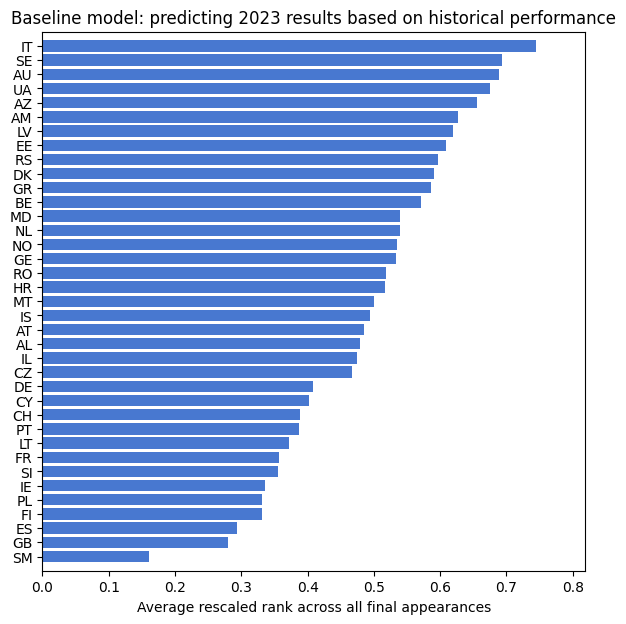

In [6]:
# Plot

n = len(predictions_2023)

fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(width=predictions_2023['rescaled_rank'], y=np.arange(n), color='#4878D0')
ax.set(
    xlim=(0, predictions_2023['rescaled_rank'].max() * 1.1),
    ylim=(-1, n),
    yticks=np.arange(n),
    yticklabels=predictions_2023.index.values,
    xlabel='Average rescaled rank across all final appearances',
    title='Baseline model: predicting 2023 results based on historical performance'
)
ax.invert_yaxis()
plt.show()

# Extra: N-fold 'cross-validation' (across all years)

We can repeat the process above but exclude each year one at a time to see how well the model can predict each year of missing data from the rest.

Mean Spearman coefficient across 24 years: 0.32610885290233116


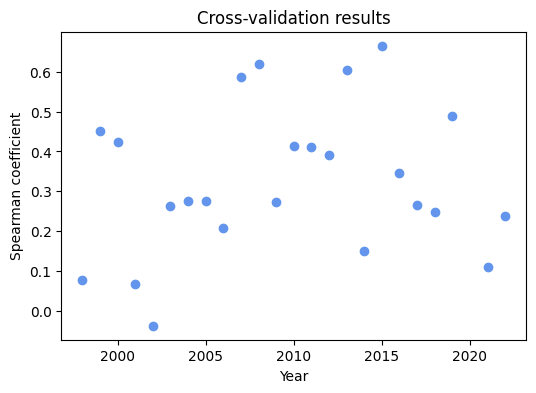

In [7]:
## NOTE: Slovakia only has one entry in the table, in 1998.
## So, when the model is 'trained' on all data excluding 1998, Slovakia doesn't get a rescaled_rank as there is no data to work with.
## The 1998 predictions therefore don't include Slovakia (the Spearman coefficient is calculated based on all other entrants in 1998).

all_years = df['year'].unique()

def get_spearman(year):
    rescaled_ranks = train(excluded_years=[year])
    predictions = predict(rescaled_ranks, year)
    actual = get_actual_ranks(year)
    # Remove Slovakia from 1998
    if year == 1998:
        predictions = predictions.query('to_code2 != "SK"')
        actual = actual.query('to_code2 != "SK"')
    return(spearman(predictions, actual))
    
spearmans = [get_spearman(year) for year in all_years]

print(f'Mean Spearman coefficient across {len(all_years)} years: {np.mean(spearmans)}')

df_xv = pd.DataFrame({'year': all_years, 'spearman': spearmans})

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_xv['year'], df_xv['spearman'], color='#6495ed')
ax.set(xlabel='Year', ylabel='Spearman coefficient', title='Cross-validation results')
plt.show()

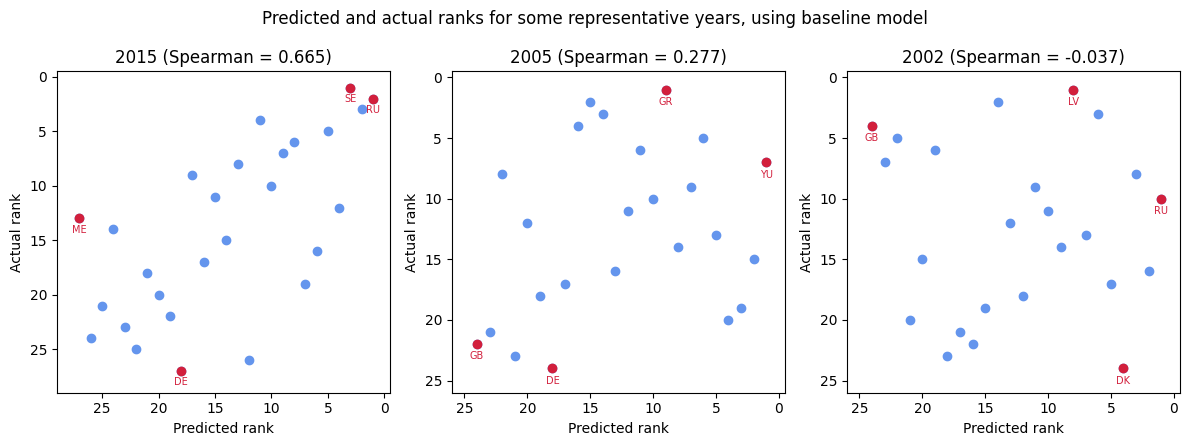

In [8]:
# Visualise some of them

df_xv_sorted = df_xv.sort_values(by='spearman').reset_index(drop=True)

# Choose some representative years
best_year = df_xv_sorted['year'].values[-1]
average_year = df_xv_sorted['year'].values[len(df_xv_sorted)//2]
worst_year = df_xv_sorted['year'].values[0]

blue = '#6495ed'
red = '#d21f3c'

fig, axs = plt.subplots(1, 3, figsize=(12, 4.5))
for year, ax in zip([best_year, average_year, worst_year], axs):
    # Calculate Spearman coefficient
    spearman = df_xv_sorted[df_xv_sorted['year'] == year]['spearman'].values[0]
    predictions = predict(train(excluded_years=[year]), year)
    actual = get_actual_ranks(year)
    both = predictions.join(actual, how='left', validate='one_to_one')
    
    # Plot
    ax.scatter(x=both['predicted_rank'], y=both['rank'], color=blue)
    ax.set(title=f'{year} (Spearman = {spearman:.3f})',
           xlabel='Predicted rank',
           ylabel='Actual rank',
           xlim=(-0.5, len(both) + 2),
           ylim=(-0.5, len(both) + 2))
    ax.invert_xaxis()
    ax.invert_yaxis()
    
    # Add in some labels
    best_predicted = both[both['predicted_rank'] == 1].index.values[0]
    worst_predicted = both[both['predicted_rank'] == len(both)].index.values[0]
    best_actual = both[both['rank'] == 1].index.values[0]
    worst_actual = both[both['rank'] == len(both)].index.values[0]
    for countries in {best_predicted, worst_predicted, best_actual, worst_actual}:
        ax.scatter(x=both.query('index in @countries')['predicted_rank'], y=both.query('index in @countries')['rank'], color=red)
        ax.text(s=countries,
                x=both.loc[countries, 'predicted_rank'],
                y=both.loc[countries, 'rank'] + 0.6,
                fontsize=7,
                ha='center',
                va='top',
                color=red)
        
    
fig.suptitle('Predicted and actual ranks for some representative years, using baseline model')
plt.tight_layout()